In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
class StatefulMultiStepLSTM(object):
    def __init__(self,batch_size, look_back, look_ahead, dropout, loss, learning_rate):
        self.batch_size = batch_size
        self.look_back = look_back
        self.look_ahead = look_ahead
        self.n_hidden = 1
        self.model = tf.keras.models.Sequential()
        self.loss = loss
        # self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.dropout = dropout

    def build_model(self):
        # first add input to hidden1
        self.model.add(
            tf.keras.layers.LSTM(
                units=120,
                batch_input_shape=(self.batch_size, self.look_back,1),
#                 batch_size=self.batch_size,
                stateful=True,
                unroll=True,
                return_sequences=True if self.n_hidden > 1 else False)
        )
        self.model.add(tf.keras.layers.Dropout(self.dropout))

        # add hidden layers
        for i in range(2, self.n_hidden + 1):
            return_sequences = True
            if i == self.n_hidden:
                return_sequences = False
            self.model.add(tf.keras.layers.LSTM(units = 120, stateful=True,return_sequences=return_sequences,unroll=True))
            self.model.add(tf.keras.layers.Dropout(self.dropout))

        # add dense layer with output dimension to get output for one time_step
        self.model.add(tf.keras.layers.Dense(units=1))

        # Repeat for look_ahead steps to get outputs for look_ahead timesteps.
        self.model.add(tf.keras.layers.RepeatVector(self.look_ahead))

        # add activation
        self.model.add(tf.keras.layers.Activation("linear"))

        # compile model and print summary
        self.model.compile(loss=self.loss, optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate,decay= .99))
        self.model.summary()
        return self.model

In [25]:
keras = tf.keras
np.random.seed(123)

def gen_data(size):
    samples = size
    sampling_rate = size/2
    freq = 200
    x = np.arange(samples)
    y = np.zeros(samples, dtype=np.float32)
    for i in range(len(y)):
        x_1 = 2*np.pi * freq * x[i] / (np.random.randint(sampling_rate/2, sampling_rate))
        
        if True in [i % j == 0 for j in np.arange(2000,2010)]:
            a = np.random.randint(85,100)/100.0
        else:
            a = np.random.randint(5,25)/100.0
        
        y[i] = a* np.sin(x_1)
    
    return y



(-1, 1)

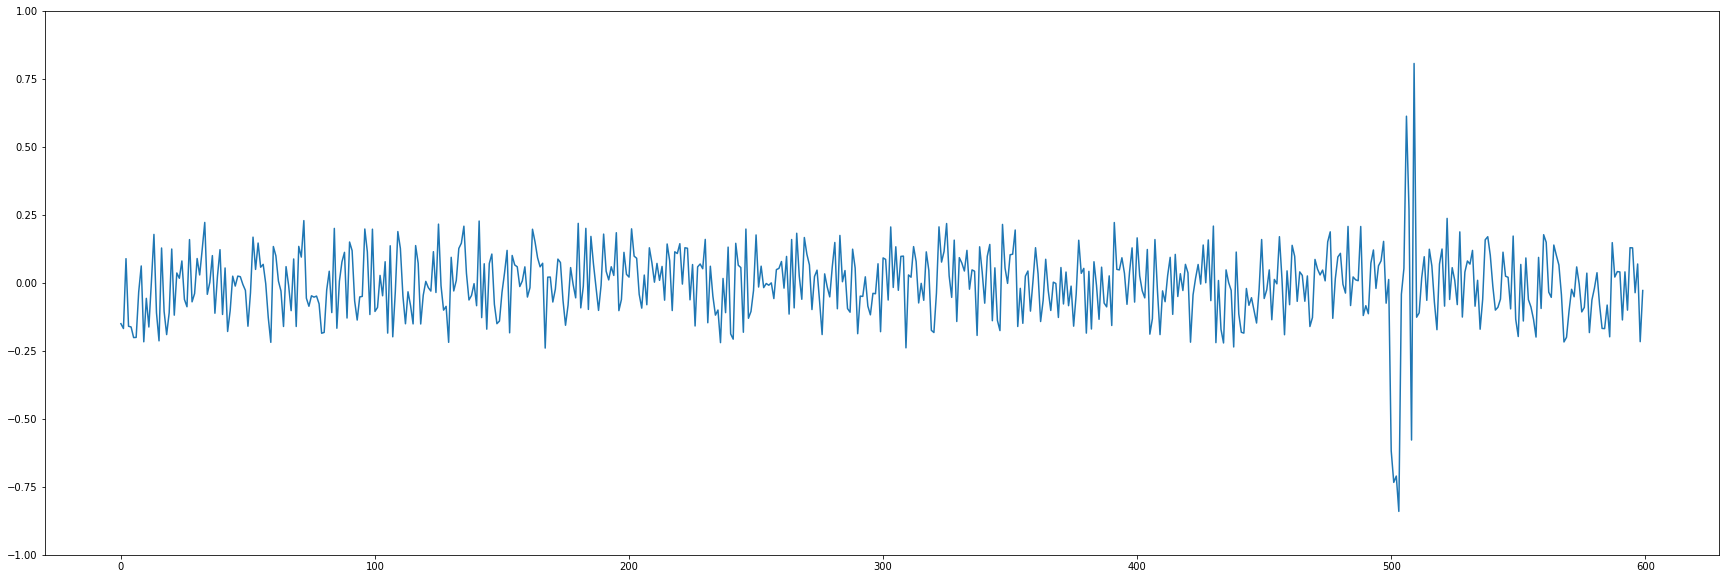

In [26]:
data = gen_data(35000)
plt.figure(figsize=(30,10))
plt.plot(data[1500:2100])
plt.ylim(-1,1)

(-1, 1)

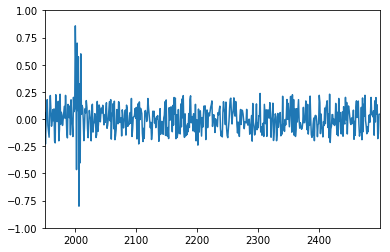

In [27]:
data = gen_data(40000)
df = pd.DataFrame(data)
df.columns = ["signal"]
df.signal[1950:2500].plot()
plt.ylim(-1,1)

In [6]:
df['anomaly'] = 0
df.head()

,signal,anomaly
0,0.000000,0
1,0.019648,0
2,0.015308,0
3,0.030503,0
4,0.051004,0


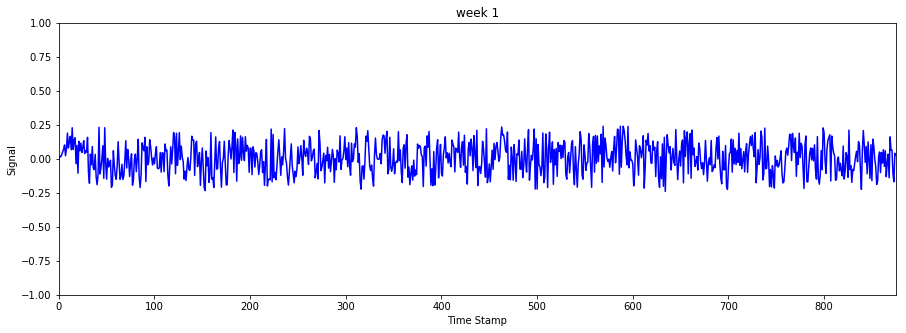

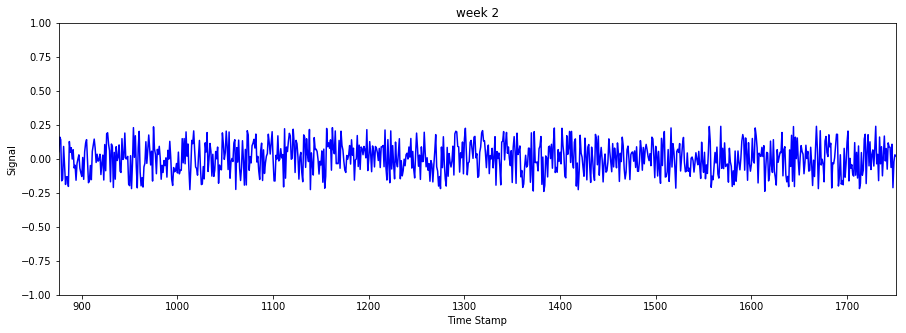

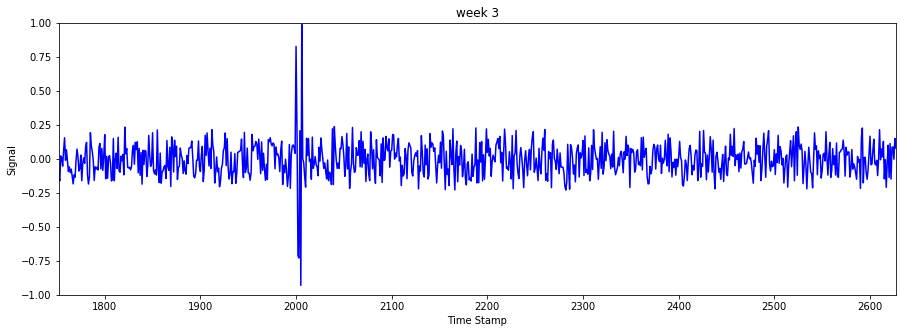

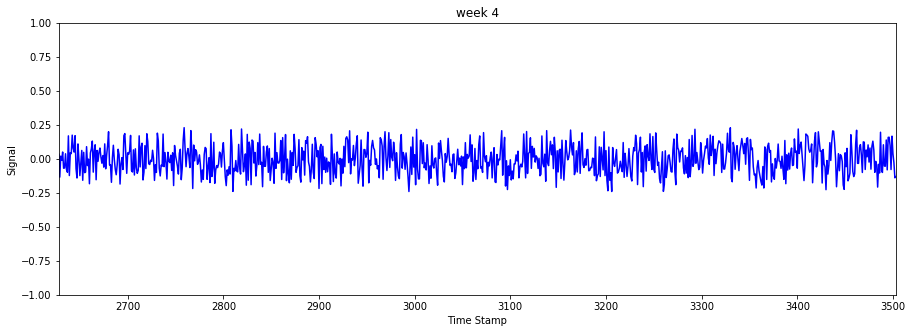

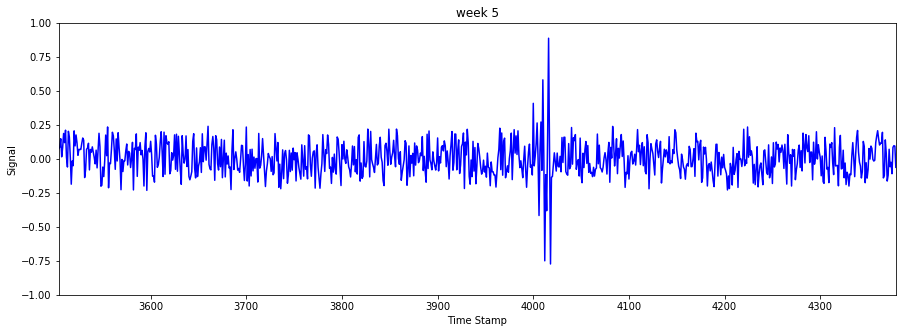

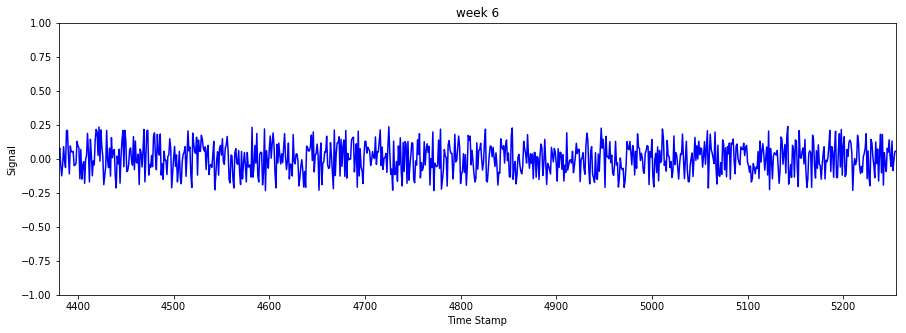

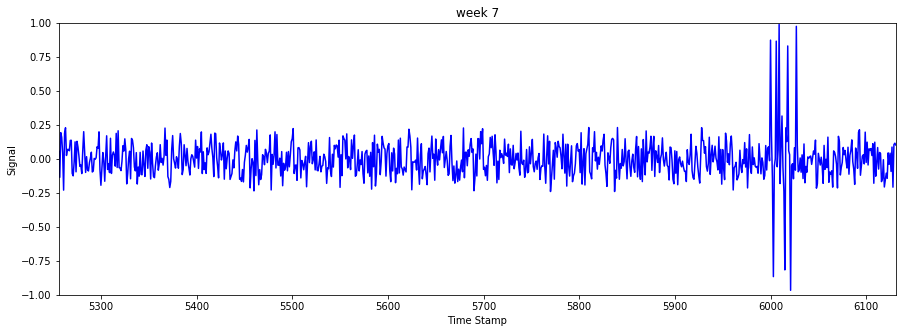

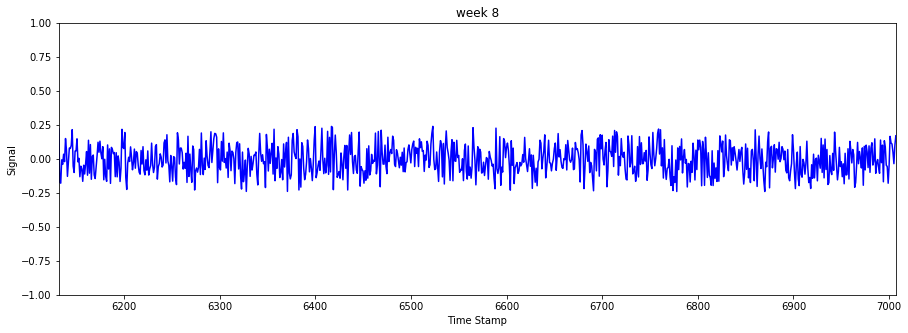

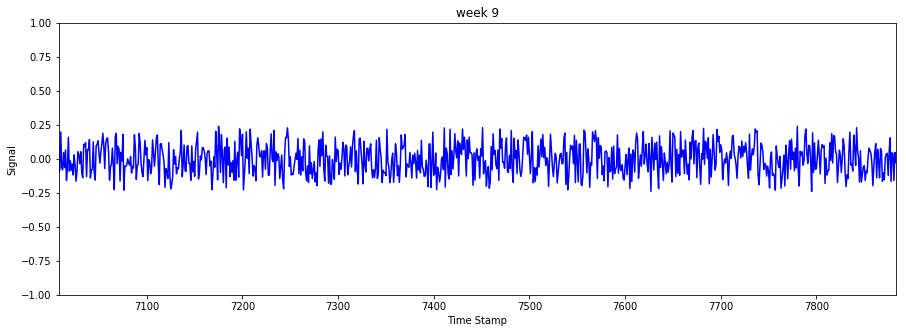

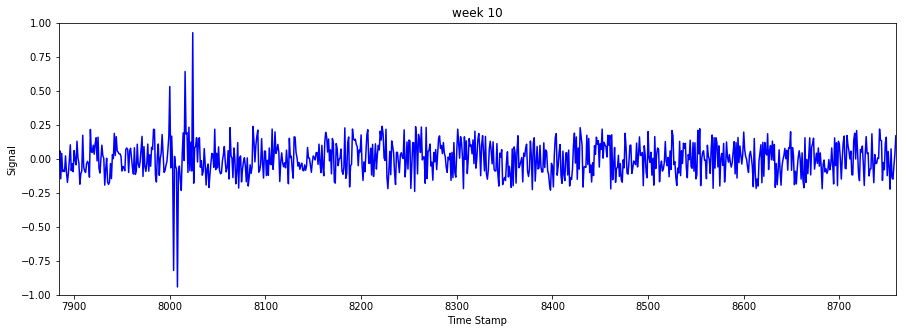

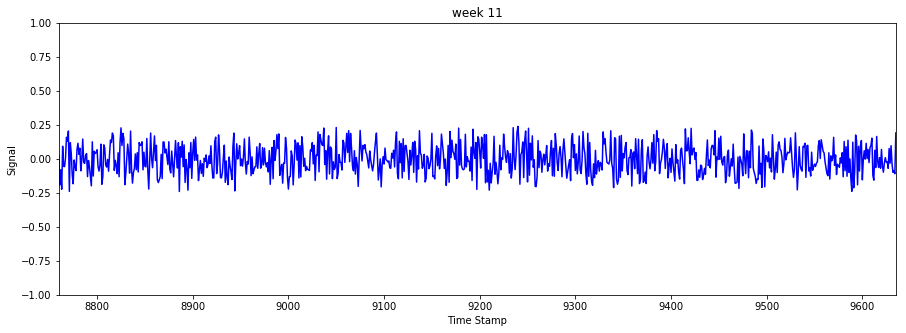

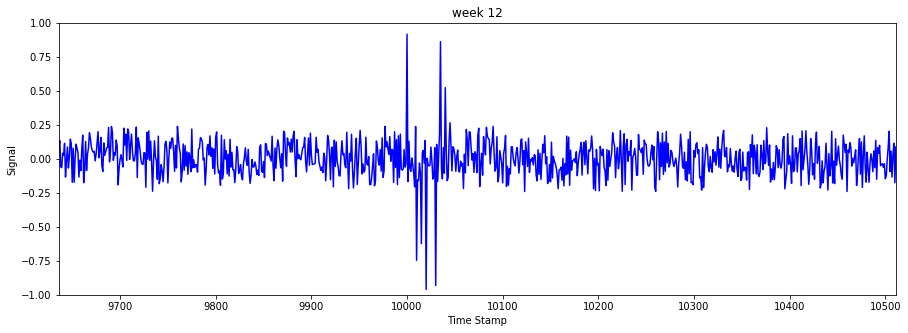

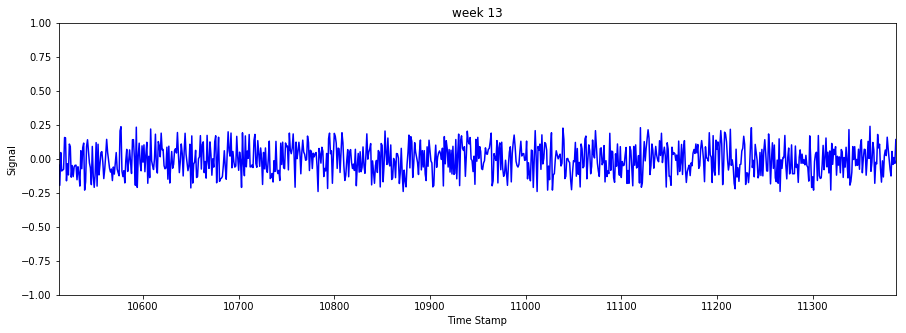

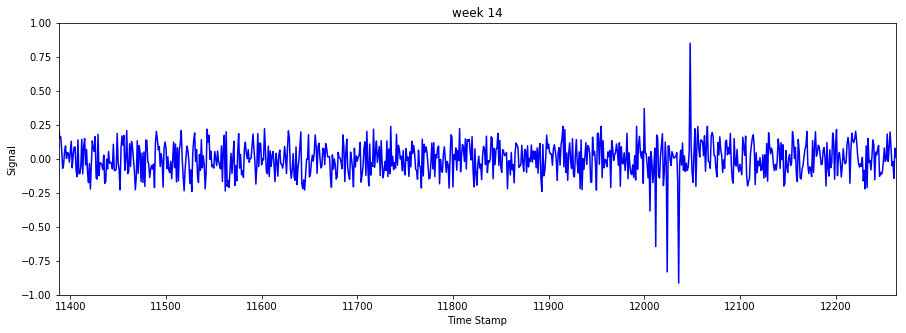

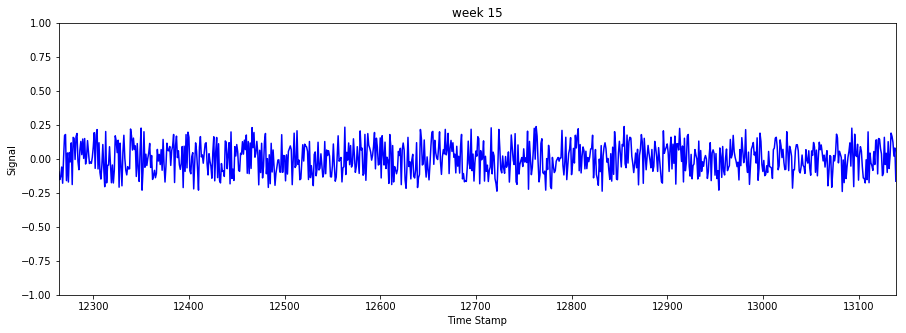

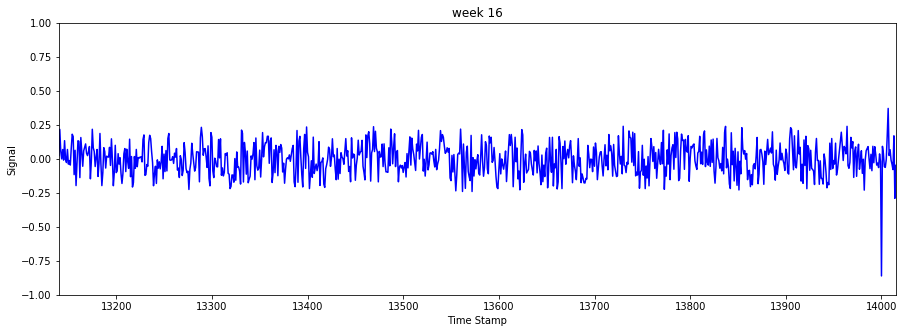

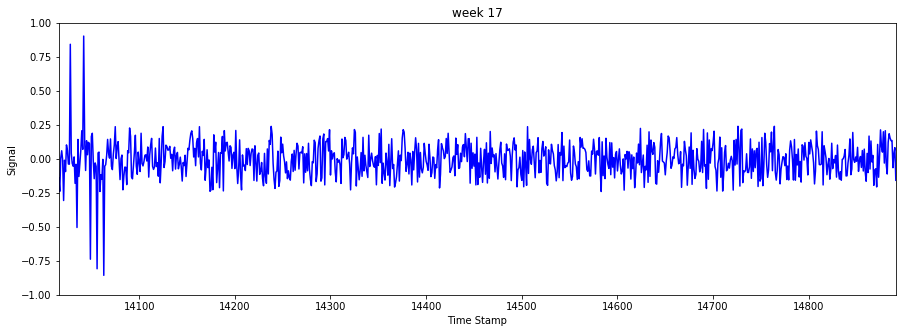

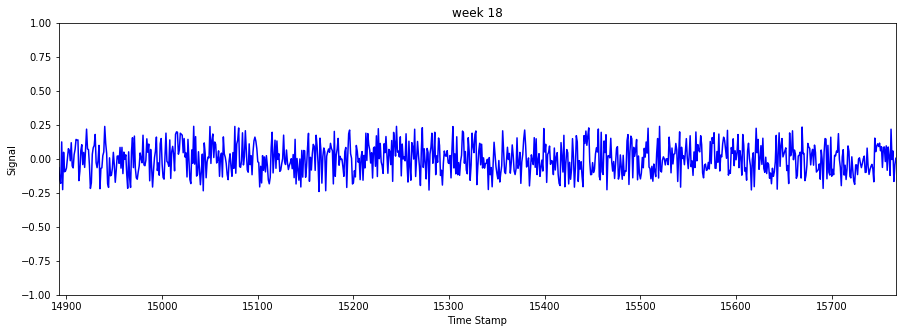

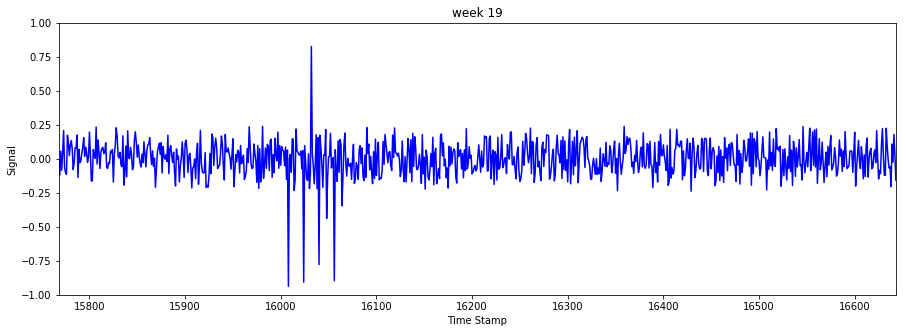

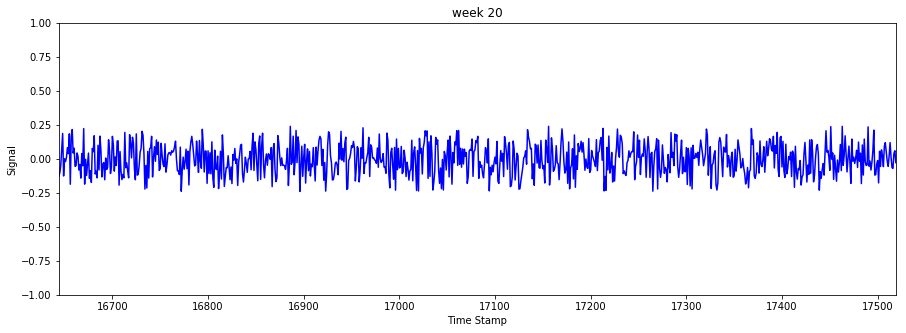

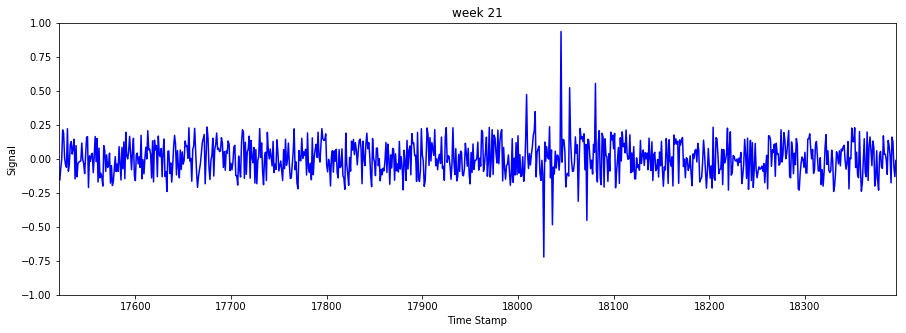

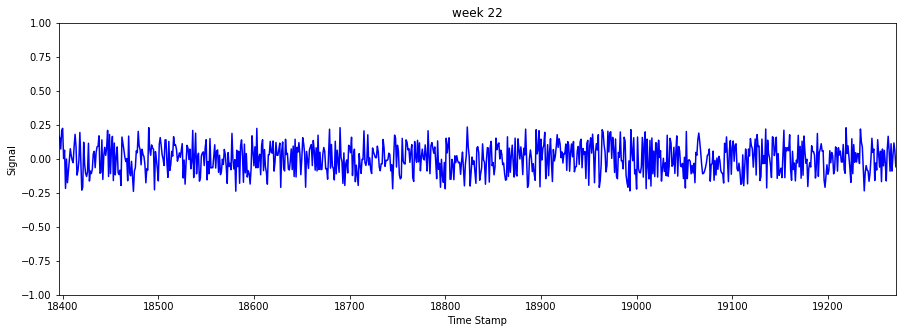

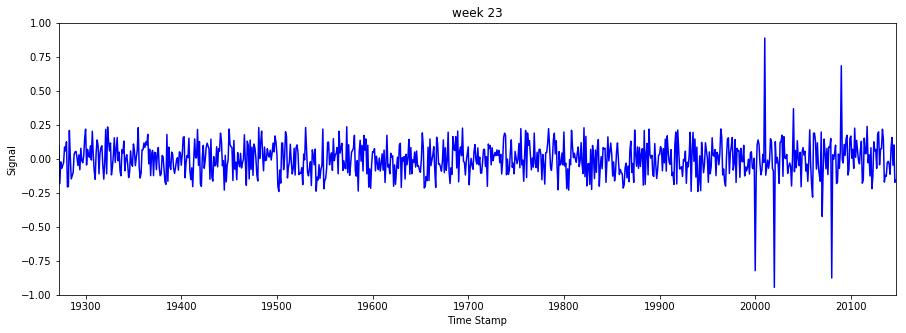

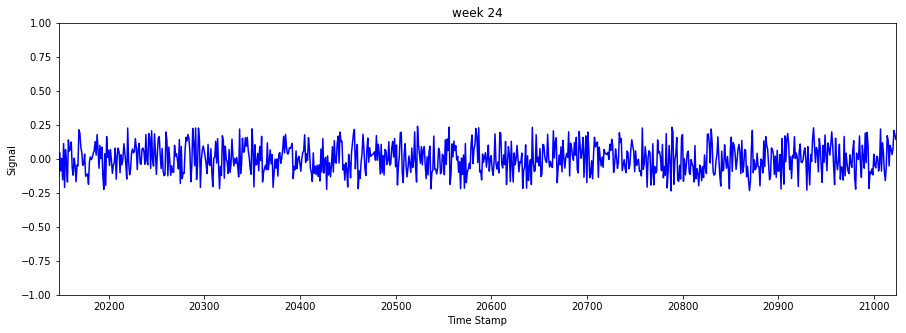

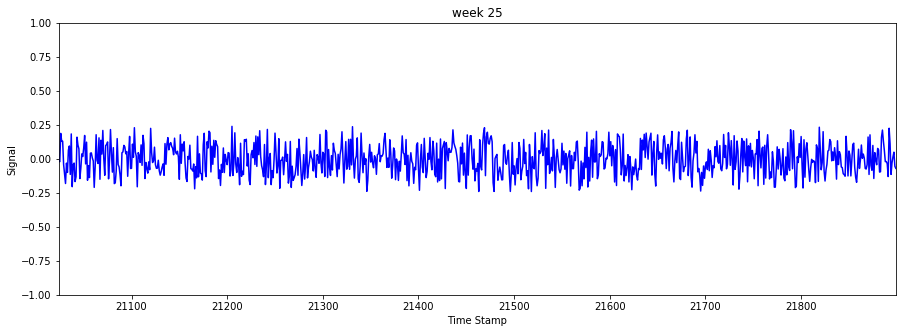

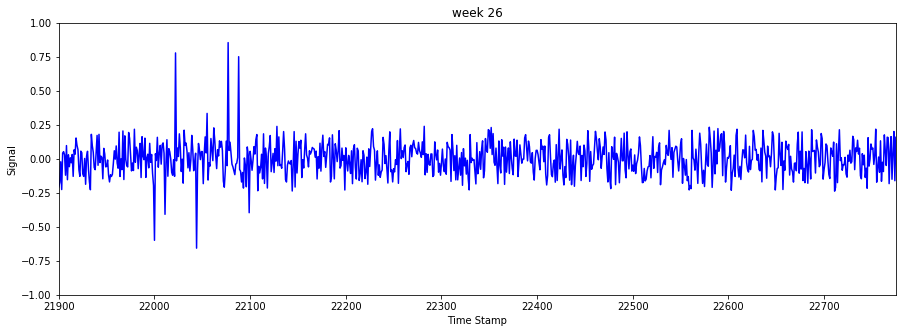

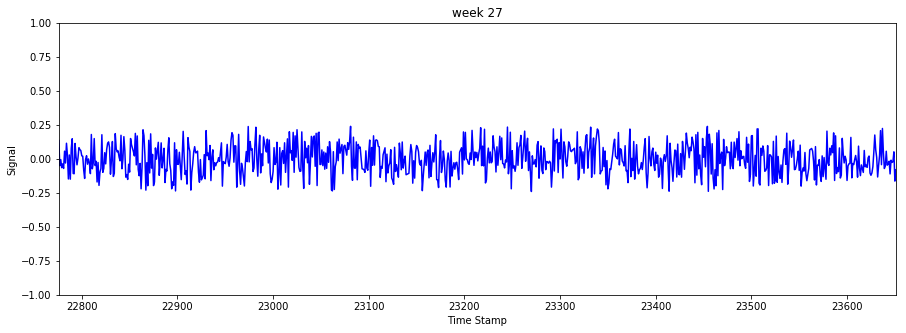

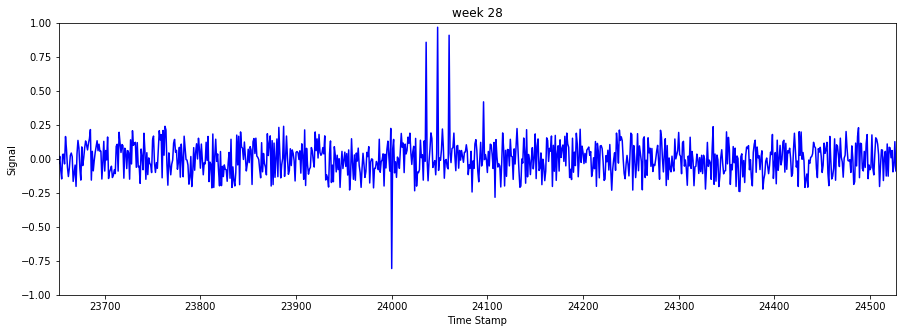

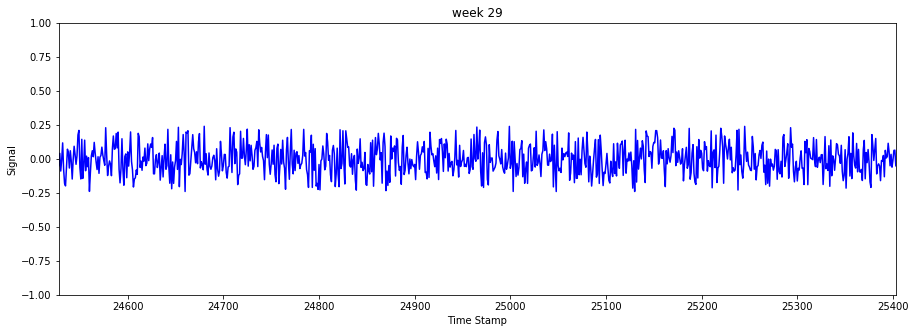

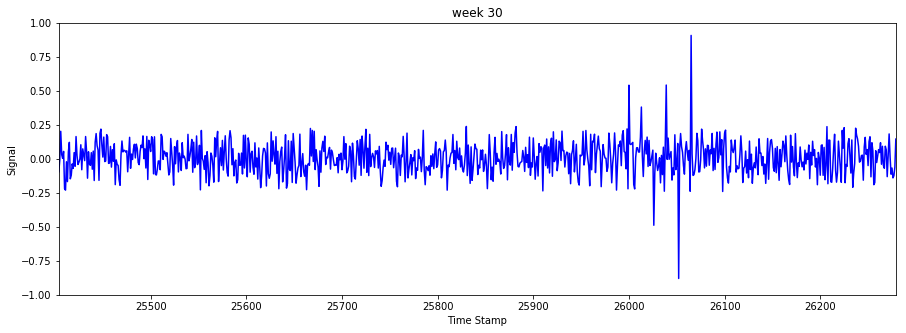

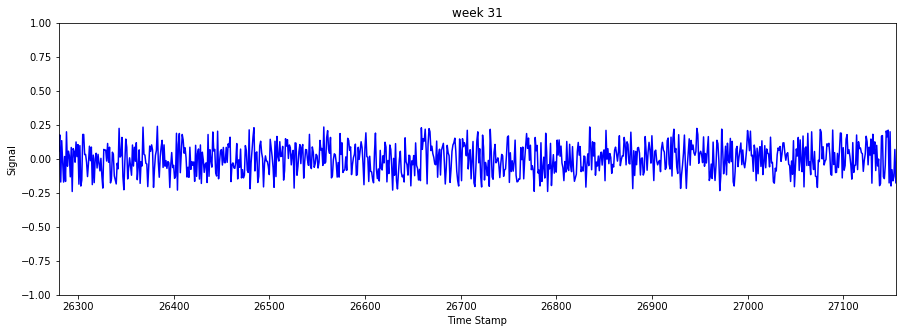

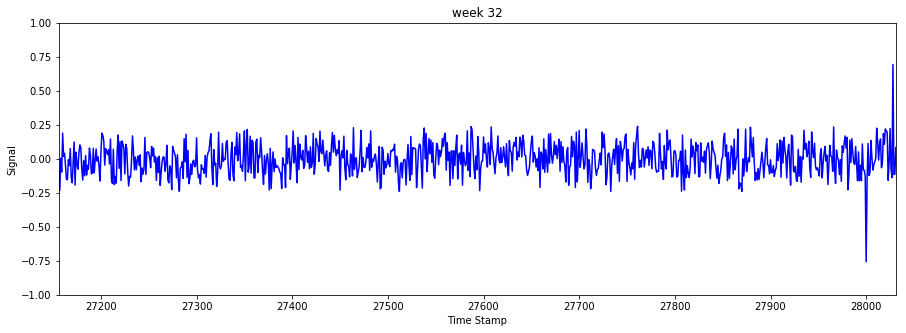

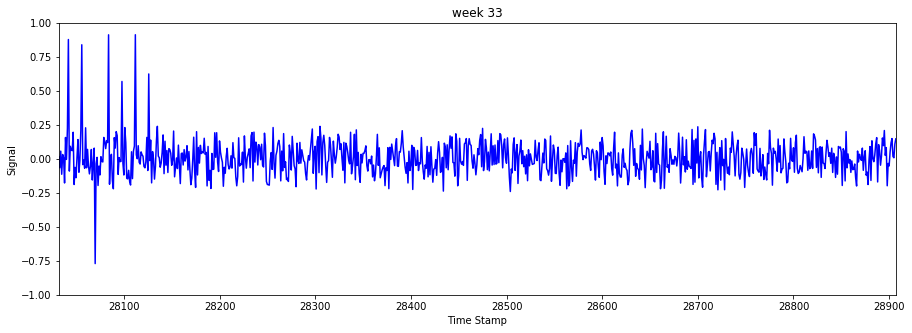

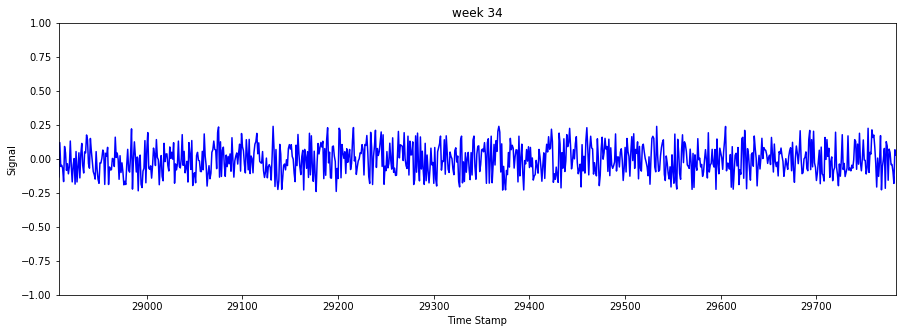

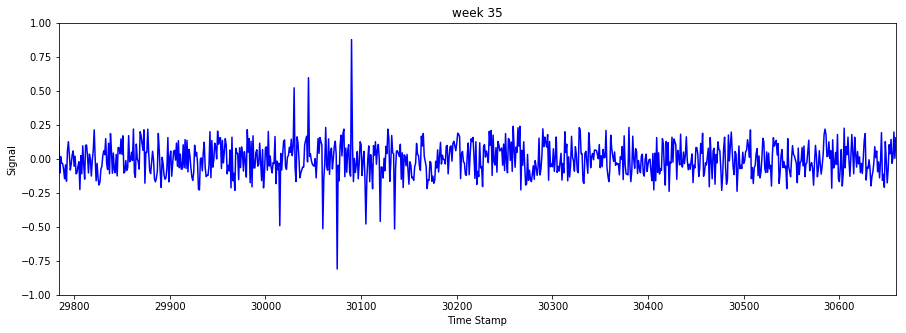

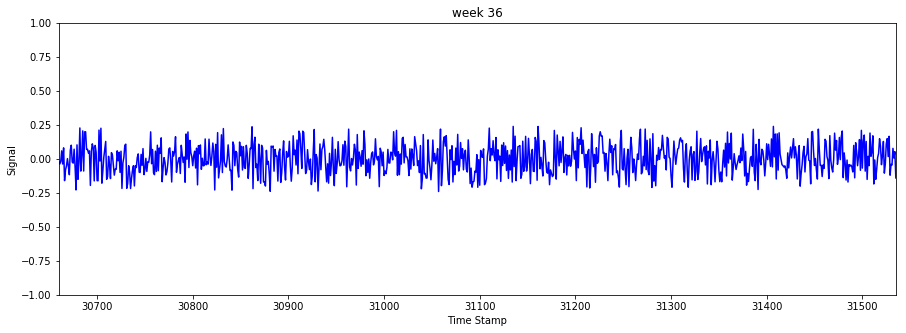

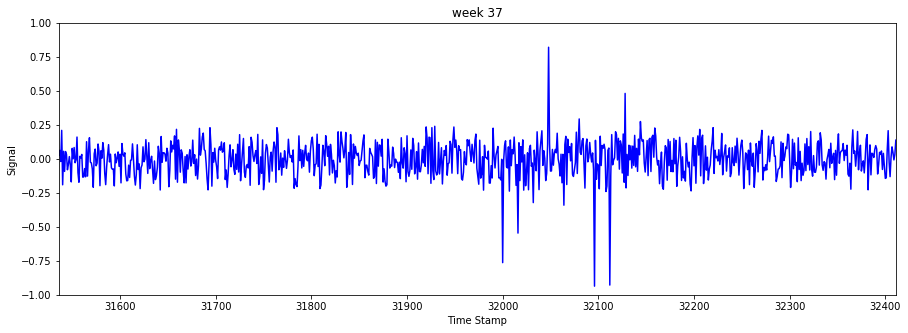

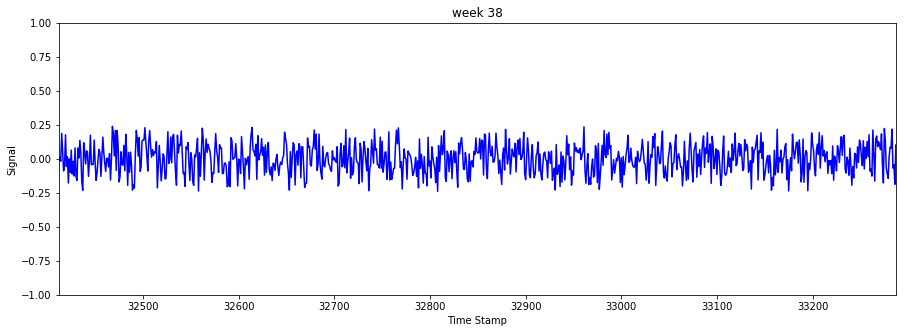

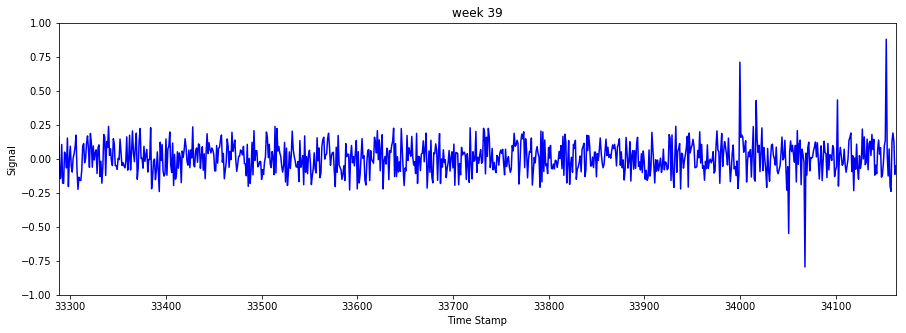

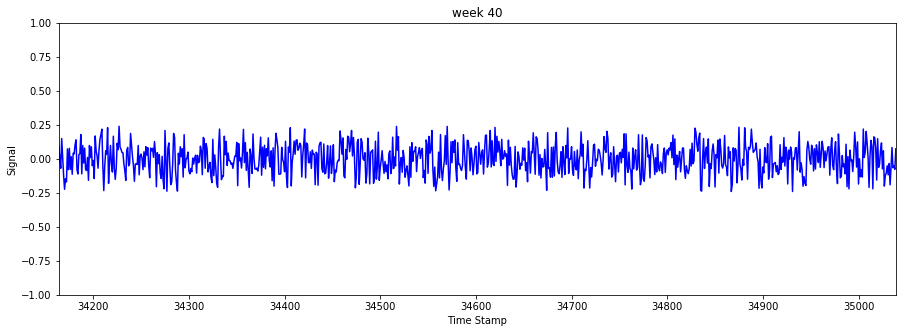

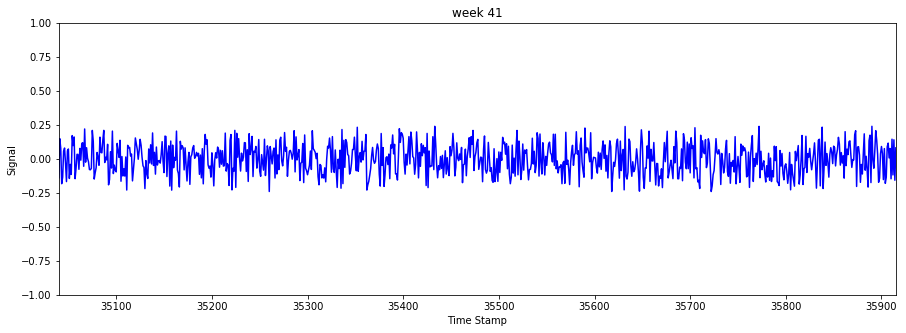

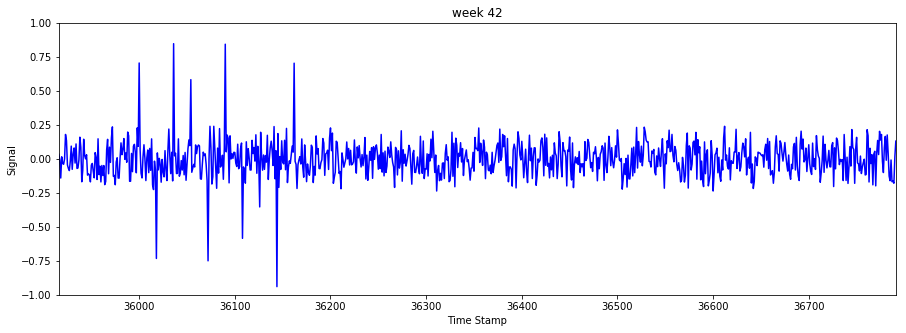

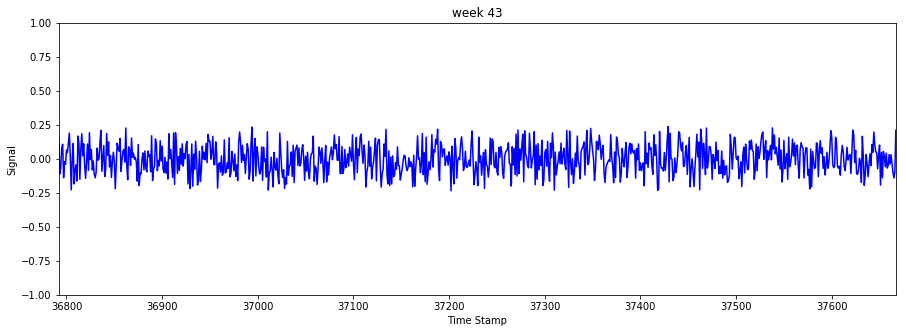

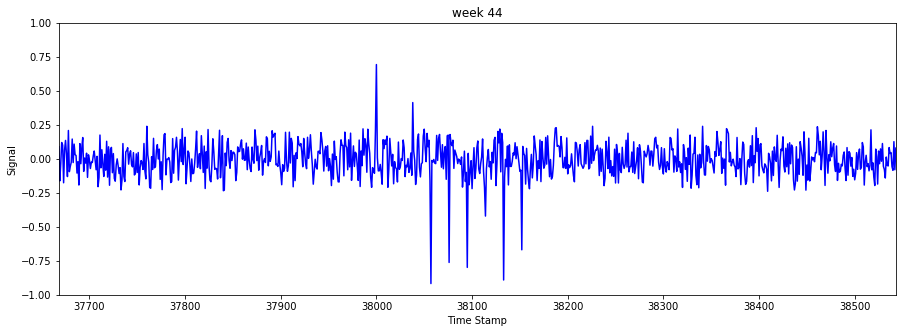

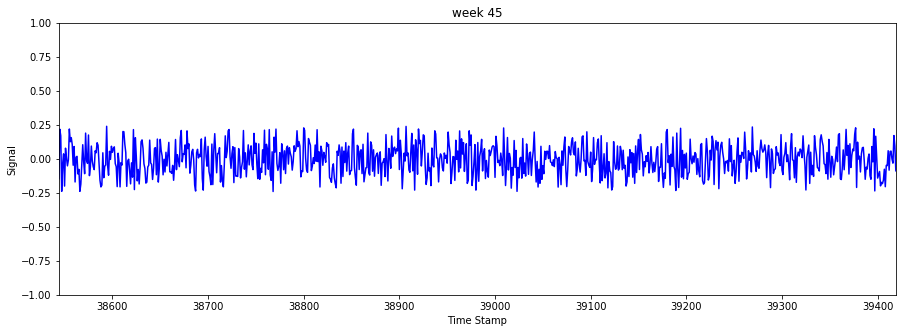

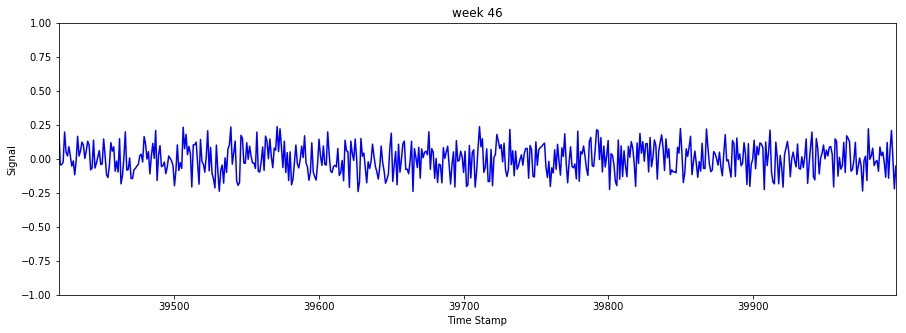

In [7]:
# iterate over a week, which would have 672 values
step = 876

for i in range(0,df.shape[0],step):
    fig = plt.figure(figsize=(15,5))
    tmp = df[i:i+step]['signal'].plot(color='blue')
    plt.title("week %s"%(i/step +1))
    plt.xlabel('Time Stamp')
    plt.ylabel('Signal')
    plt.ylim(-1,1)
    plt.show()
    if i == 100:
        break

In [8]:
anomaly_weeks = [3, 5, 7, 10, 12, 14, 16, 17, 19, 21, 23, 26, 28, 30, 32, 33, 35, 37, 39, 42, 44]
validation1_weeks = [29, 31, 34, 38, 40]   # non-anomalous data
validation2_weeks = [5, 7, 10, 4, 11, 13] #mix of anomalous data
test_weeks = [42, 39, 37, 1, 6, 8] # mix of anomals data

df_train_list = []
df_valid1_list = []
df_valid2_list = []
df_test_list = []

for i in range(0,df.shape[0],step):
    #df[i:i+step].plot(figsize=(30,10))
    week = i/step +1
    if week in validation1_weeks:
        df_valid1_list.append(df[i:i+step])  
    elif week in validation2_weeks:
        if week in anomaly_weeks:
            df[i:i+step]['anomaly'] =1
        df_valid2_list.append(df[i:i+step])
    elif week in test_weeks:
        if week in anomaly_weeks:
            df[i:i+step]['anomaly'] =1
        df_test_list.append(df[i:i+step])
    else:
        if week not in anomaly_weeks:
            df_train_list.append(df[i:i+step])
        
print len(df_train_list)
print len(df_valid1_list)
print len(df_valid2_list)
print len(df_test_list)

14
5
6
6


/home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
df_validation1 = pd.concat(df_valid1_list)
df_validation2 = pd.concat(df_valid2_list)
df_dict = {}
df_dict['train'] = df_train
df_dict['test'] = df_test
df_dict['validation1'] = df_validation1
df_dict['validation2'] = df_validation2

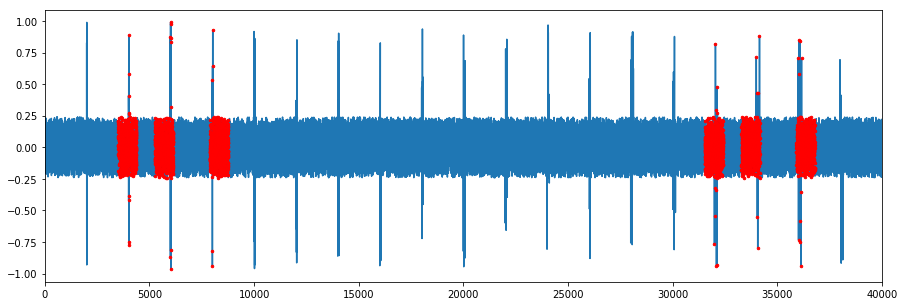

In [10]:
plt.figure()
df['signal'].plot(figsize=(15,5))
rows = df[df.anomaly.isin([1])].itertuples()
for row in rows:
    plt.plot(row[0], row[1], 'r.', markersize=5.0)
plt.show()

Size of test: 5256
Size of validation1: 4380
Size of validation2: 5256
Size of train: 11968
Total: 26860
Ratio of test: 0.195681
Ratio of validation1: 0.163068
Ratio of validation2: 0.195681
Ratio of train: 0.445570


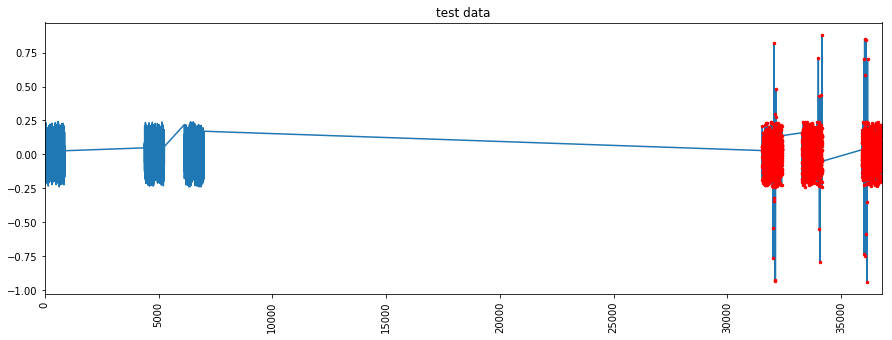

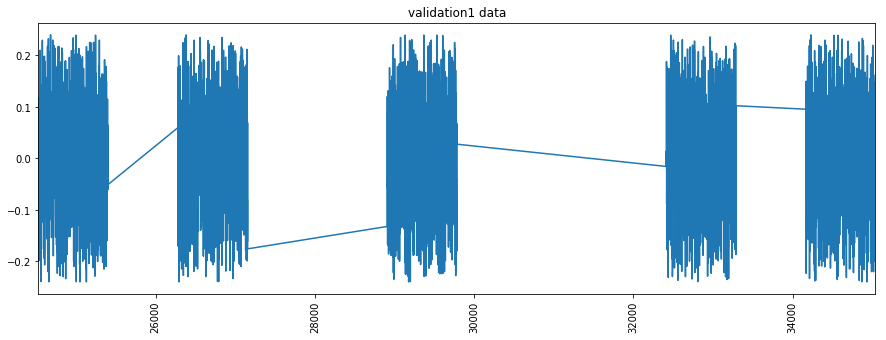

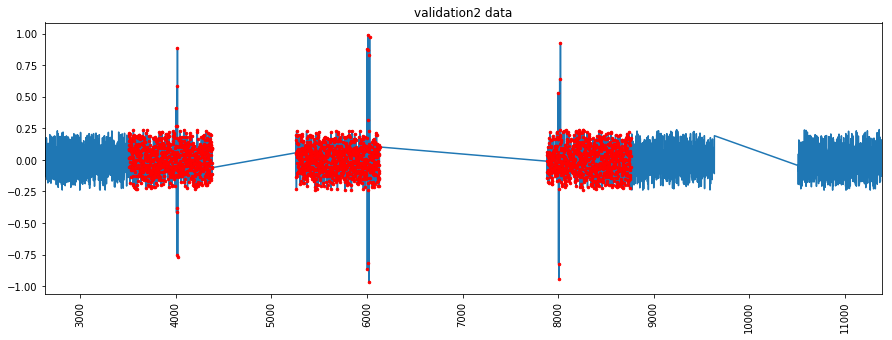

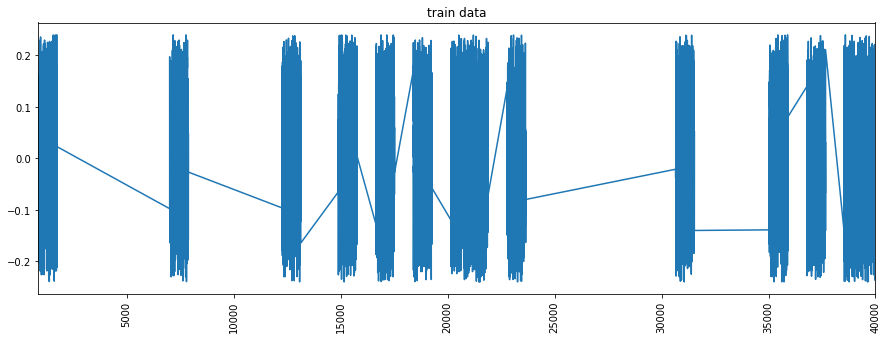

In [11]:
count = 0
for key in df_dict:
    print "Size of %s: %d"%(key,df_dict[key].shape[0])
    count += df_dict[key].shape[0]
print "Total: %d"%(count)

for key in df_dict:
    print "Ratio of %s: %f"%(key,float(df_dict[key].shape[0])/count)

for key in df_dict:
    plt.figure()
    df_tmp = df_dict[key]
    df_tmp['signal'].plot(figsize=(15,5))
    rows = df_tmp[df_tmp.anomaly.isin([1])].itertuples()
    for row in rows:
        plt.plot(row[0], row[1], 'r.', markersize=5.0)
    plt.xticks(rotation='vertical')
    plt.title("%s data"%(key))
    plt.show()

In [12]:
for key in df_dict:
    np.save("./%s"%(key),df_dict[key])

# Data Prep -Cont

In [64]:
def prepare_seq2seq_data(dataset, look_back, look_ahead):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - look_ahead):
        input_seq = dataset[i:(i + look_back)]
        output_seq = dataset[i + look_back:(i + look_back + look_ahead)]
        dataX.append(input_seq)
        dataY.append(output_seq)
    dataX = np.reshape(np.array(dataX),[-1,look_back,1])
    dataY = np.reshape(np.array(dataY),[-1,look_ahead,1])
    return dataX,dataY


train = np.load("train.npy")
validation1 = np.load("validation1.npy")
validation2 = np.load("validation2.npy")
test = np.load("test.npy")

original_test = test.copy()

train_scaler = StandardScaler()
train = train_scaler.fit_transform(train[:, 0])

valid1 = train_scaler.transform(validation1[:, 0])
valid2 = train_scaler.transform(validation2[:, 0])
valid2_labels = validation2[:,1]
test_labels = test[:, 1]
test = train_scaler.transform(test[:, 0])

/home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning

In [65]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print "Resetting states before epoch %d"%(epoch)
        self.model.reset_states()

def train_stateful_model(model, x_train, y_train, batch_size, epochs, shuffle, validation, validation_data, patience):
    if validation:
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

        history_callback = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs, validation_data = validation_data,
                                     shuffle=shuffle, verbose=1, callbacks=[ResetStatesCallback(),early_stopping])
    else:
        history_callback = model.fit(x_train, y_train, batch_size=batch_size, epochs= epochs,callbacks=[ResetStatesCallback()],
                                     shuffle=shuffle, verbose=1)
    print("Training loss per epoch: %s" % str(history_callback.history['loss']))
    if validation:
        print("Validation  Loss per epoch: %s" % str(history_callback.history["val_loss"]))
        
    print(history_callback.history.keys())
    return history_callback
    # for epoch in range(epochs):
    #     model.fit(x_train, y_train, batch_size=batch_size, epochs=1,shuffle=shuffle, verbose=2)
    #     model.reset_states()


look_back = 12
look_ahead =1

x_train, y_train = prepare_seq2seq_data(train, look_back=look_back, look_ahead=look_ahead)
x_valid1, y_valid1 = prepare_seq2seq_data(valid1, look_back=look_back, look_ahead=look_ahead)

x_valid2, y_valid2 = prepare_seq2seq_data(valid2, look_back=look_back, look_ahead=look_ahead)
x_valid2_lab, y_valid2_lab = prepare_seq2seq_data(valid2_labels, look_back=look_back, look_ahead=look_ahead)

x_test_lab, y_test_lab = prepare_seq2seq_data(test_labels, look_back=look_back, look_ahead=look_ahead)
x_test, y_test = prepare_seq2seq_data(test, look_back=look_back, look_ahead=look_ahead)

In [66]:
batch_size = 256
if batch_size > 1:
    n_train_batches = len(x_train)/batch_size
    len_train = n_train_batches * batch_size
    if len_train < len(x_train):
        x_train = x_train[:len_train]
        y_train = y_train[:len_train]

    n_validation1_batches = len(x_valid1)/batch_size
    len_validation1 = n_validation1_batches * batch_size
    if n_validation1_batches * batch_size < len(x_valid1):
        x_valid1 = x_valid1[:len_validation1]
        y_valid1 = y_valid1[:len_validation1]

    n_validation2_batches = len(x_valid2) / batch_size
    len_validation2 = n_validation2_batches * batch_size
    if n_validation2_batches * batch_size < len(x_valid2):
        x_valid2 = x_valid2[:len_validation2]
        y_valid2 = y_valid2[:len_validation2]

    n_test_batches = len(x_test)/batch_size
    len_test = n_test_batches * batch_size
    if n_test_batches * batch_size < len(x_test):
        x_test = x_test[:len_test]
        y_test = y_test[:len_test]
        
stateful_lstm = StatefulMultiStepLSTM(
    batch_size=batch_size, 
    look_back=look_back, 
    look_ahead=look_ahead, 
    dropout=.01, 
    loss='mse', 
    learning_rate=0.2)
model = stateful_lstm.build_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (256, 120)                58560     
_________________________________________________________________
dropout_1 (Dropout)          (256, 120)                0         
_________________________________________________________________
dense_1 (Dense)              (256, 1)                  121       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (256, 1, 1)               0         
_________________________________________________________________
activation_1 (Activation)    (256, 1, 1)               0         
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________


In [67]:
x_train.shape, y_train.shape

((11776, 12, 1), (11776, 1, 1))

In [68]:
history = train_stateful_model(model=model, x_train=x_train, y_train=y_train, epochs=50, batch_size=batch_size,
                    shuffle=False, validation=True, validation_data=(x_valid1, y_valid1), patience=30)

Train on 11776 samples, validate on 4352 samples
Resetting states before epoch 0
Epoch 1/50
11776/11776 [==============================] - 1s 119us/sample - loss: 10.6352 - val_loss: 1.9053
Resetting states before epoch 1
Epoch 2/50
11776/11776 [==============================] - 0s 34us/sample - loss: 1.3507 - val_loss: 1.1043
Resetting states before epoch 2
Epoch 3/50
11776/11776 [==============================] - 0s 33us/sample - loss: 1.0827 - val_loss: 1.0549
Resetting states before epoch 3
Epoch 4/50
11776/11776 [==============================] - 0s 39us/sample - loss: 1.0541 - val_loss: 1.0306
Resetting states before epoch 4
Epoch 5/50
11776/11776 [==============================] - 0s 34us/sample - loss: 1.0478 - val_loss: 1.0292
Resetting states before epoch 5
Epoch 6/50
11776/11776 [==============================] - 0s 37us/sample - loss: 1.0496 - val_loss: 1.0219
Resetting states before epoch 6
Epoch 7/50
11776/11776 [==============================] - 0s 32us/sample - loss: 1.

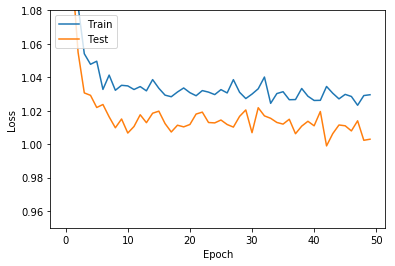

In [69]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(0.95,1.08)
plt.show()

In [70]:
validation2_loss = model.evaluate(x_valid2, y_valid2, batch_size=batch_size, verbose=1)
test_loss = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

5120/5120 [==============================] - 0s 13us/sample - loss: 1.1864


In [73]:
predictions = model.predict(x_test, batch_size=batch_size)
print(predictions[0])
predictions = train_scaler.inverse_transform(predictions)
print(predictions[0], original_test[0])

y = train_scaler.inverse_transform(y_test)
y_true = y[:, 0].flatten()

[[0.04048574]]
(array([[0.00378713]], dtype=float32), array([0., 0.]))


In [74]:
def get_diagonals(input):
    #fetch diagonals in a list
    diagonals = [input[::-1, :].diagonal(i) for i in range(-input.shape[0] + 1, 1)]
    return diagonals


def make_plots(context,predictions_timesteps,true_values,look_ahead,title):
    step = 1
    if look_ahead > 1:
        step = look_ahead - 1
    for idx, i in enumerate(np.arange(0, look_ahead, step)):
        fig = plt.figure(figsize=(30,10))
        plt.ylim(-1.5,1.5)
        #plt.title(title+" Timestep: %d "%i)
        plt.xlabel("Time Step")
        plt.ylabel("Power Consumption")
        plt.plot(true_values, label="actual", linewidth=1)
        plt.plot(predictions_timesteps[:, i], label="prediction", linewidth=1, linestyle="--")
        error = abs(true_values - predictions_timesteps[:, i])-1.5
        plt.plot(error, label="error", linewidth=0.5)
        plt.legend()
        plt.tight_layout()
    plt.show()

In [94]:
diagonals = get_diagonals(predictions)

In [95]:
for idx, diagonal in enumerate(diagonals):
    diagonal = diagonal.flatten()
    # missing value filled with the first value
    diagonals[idx] = np.hstack((diagonal, np.full(look_ahead - len(diagonal), diagonal[0])))
predictions_timesteps = np.asarray(diagonals)
predictions_timesteps.shape

(5120, 1)

In [96]:
for i in range(look_ahead):
    print("%s RMSE on %d timestep prediction %f" % ( "Train",
        (i + 1), mean_squared_error(y_true, predictions_timesteps[:, i]) ** 0.5))

Train RMSE on 1 timestep prediction 0.120929


In [97]:
shifted_1 = np.roll(y_true, 1)

In [98]:
print(" %s RMSE Naive One Timestep Shift %f","Train",
                 mean_squared_error(y_true[1:], shifted_1[1:]) ** 0.5)

(' %s RMSE Naive One Timestep Shift %f', 'Train', 0.16871054262007554)


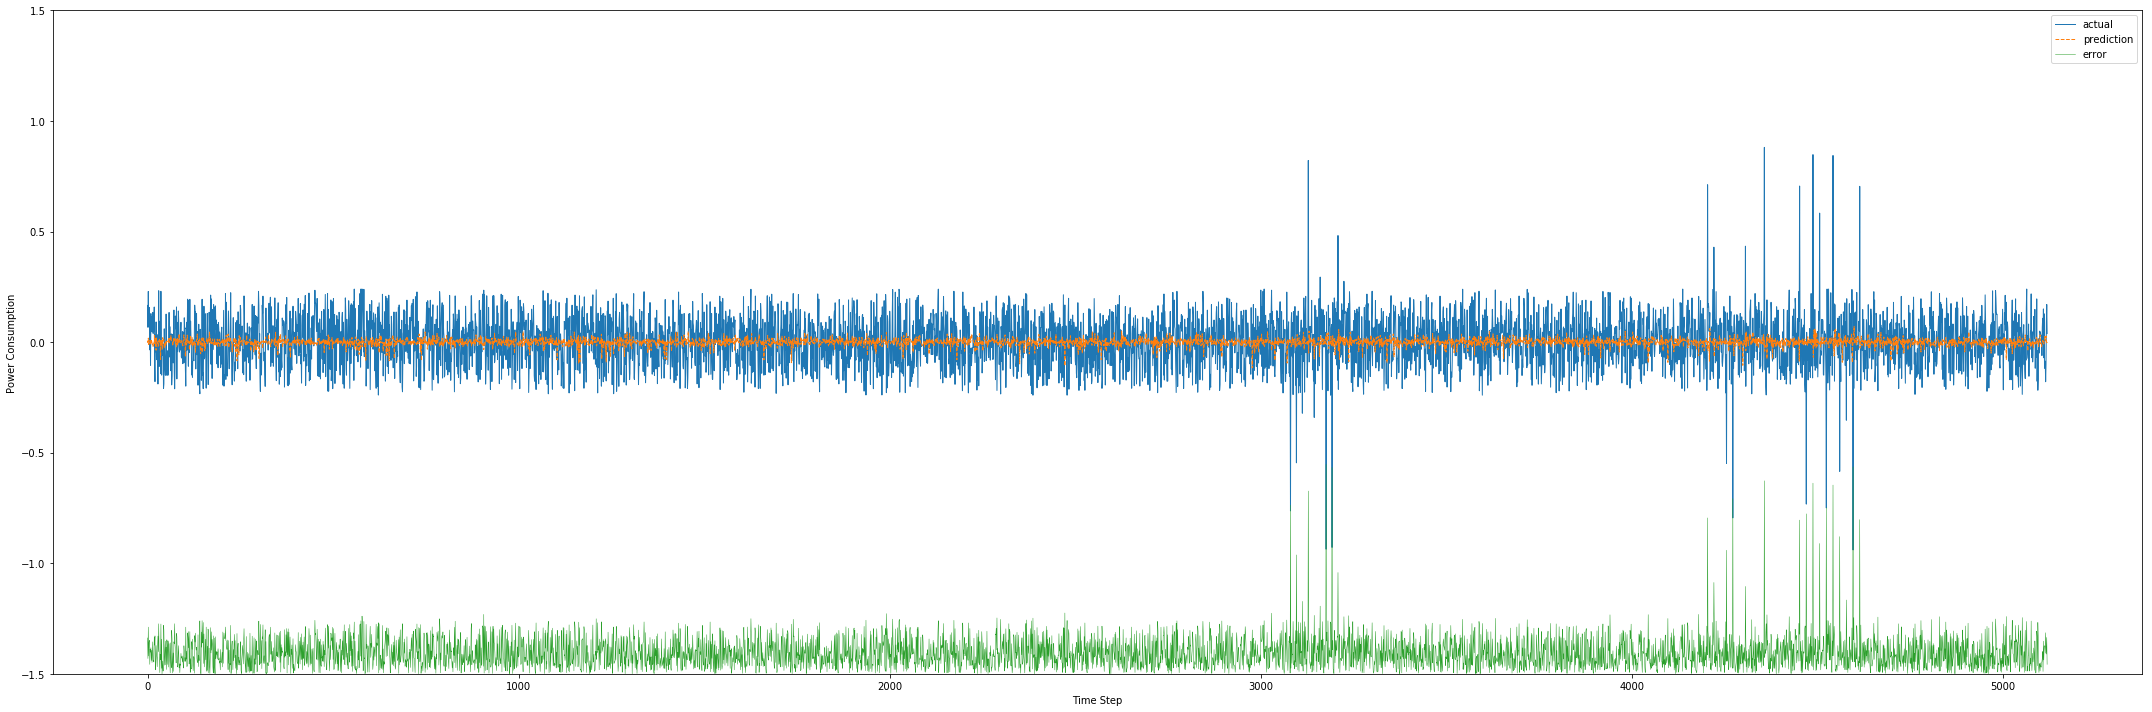

In [99]:
make_plots("Train", predictions_timesteps, y_true, look_ahead, "CCL vs Depth" )

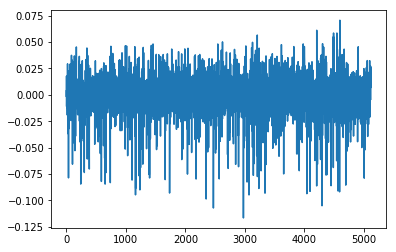

In [93]:
plt.plot(predictions.reshape(len(predictions), 1))